## **1. DATA ACQUISITION AND PREPROCESSING**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Data acquisition
import yfinance as yf

print("=" * 80)
print("STOCK PRICE FORECASTING: ARIMA VS LSTM")
print("=" * 80)

STOCK PRICE FORECASTING: ARIMA VS LSTM


## ***1.1 Data Acquisitio***

In [ ]:
print("\n[1] DATA ACQUISITION")
print("-" * 80)

# Download stock data - Using Apple (AAPL) as example
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2024-10-01"

print(f"Downloading {ticker} stock data from {start_date} to {end_date}...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

print(f"✓ Data downloaded: {len(data)} observations")
print(f"✓ Date range: {data.index[0]} to {data.index[-1]}")
print(f"\nData shape: {data.shape}")
print(f"\nFirst few rows:\n{data.head()}")


[1] DATA ACQUISITION
--------------------------------------------------------------------------------
✓ Data downloaded: 1194 observations
✓ Date range: 2020-01-02 00:00:00 to 2024-09-30 00:00:00

Data shape: (1194, 5)

First few rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538521  72.598899  71.292311  71.545897  135480400
2020-01-03  71.833290  72.594055  71.608685  71.765667  146322800
2020-01-06  72.405670  72.444313  70.703005  70.954181  118387200
2020-01-07  72.065147  72.671341  71.845369  72.415337  108872000
2020-01-08  73.224403  73.526295  71.768079  71.768079  132079200


## ***1.2 Data Cleaning***

In [ ]:
print("\n[2] DATA CLEANING")
print("-" * 80)

# Check for missing values
print(f"Missing values:\n{data.isnull().sum()}")

# Handle missing values if any
if data.isnull().sum().sum() > 0:
    print("✓ Forward filling missing values...")
    data = data.fillna(method='ffill')

# Focus on closing price for forecasting
df = data[['Close']].copy()
df.columns = ['Close']

print(f"✓ Using 'Close' price for forecasting")
print(f"✓ Clean dataset shape: {df.shape}")

# Basic statistics
print(f"\nBasic Statistics:")
print(df.describe())


[2] DATA CLEANING
--------------------------------------------------------------------------------
Missing values:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64
✓ Using 'Close' price for forecasting
✓ Clean dataset shape: (1194, 1)

Basic Statistics:
             Close
count  1194.000000
mean    147.361057
std      38.226837
min      54.316940
25%     124.563675
50%     148.066124
75%     172.459538
max     233.461975


## ***1.3 Feature Engineering***


[3] FEATURE ENGINEERING
--------------------------------------------------------------------------------
✓ Created technical indicators: MA7, MA21, MA50, Volatility, Returns
✓ Created lagged features: Lag_1 to Lag_5
✓ Feature dataset shape: (1145, 11)
✓ Saved visualization: data_exploration.png


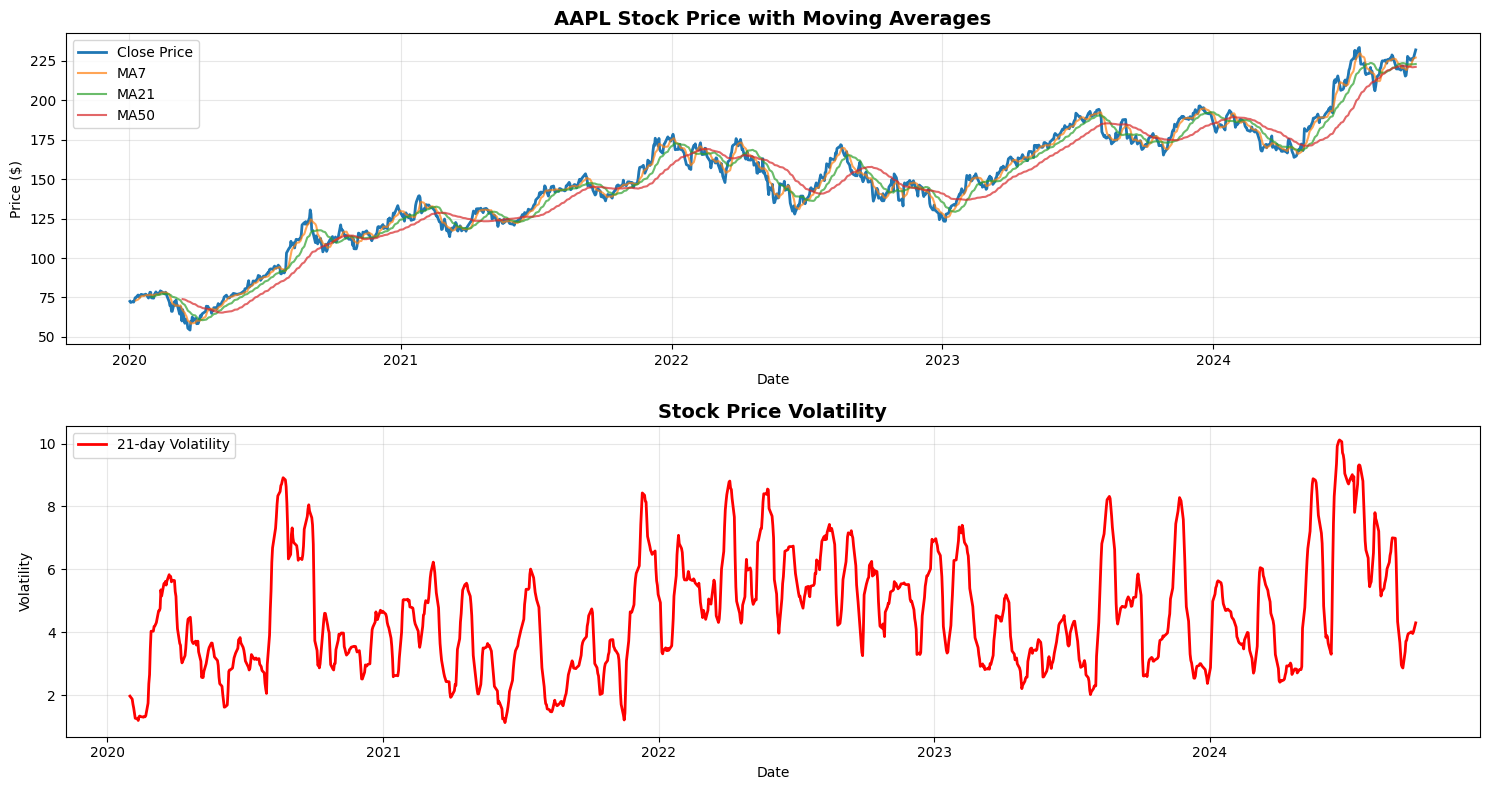

In [ ]:

print("\n[3] FEATURE ENGINEERING")
print("-" * 80)

# Create technical indicators
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Volatility'] = df['Close'].rolling(window=21).std()
df['Returns'] = df['Close'].pct_change()

# Create lagged features
for i in range(1, 6):
    df[f'Lag_{i}'] = df['Close'].shift(i)

# Drop NaN values created by rolling windows
df_features = df.dropna().copy()

print(f"✓ Created technical indicators: MA7, MA21, MA50, Volatility, Returns")
print(f"✓ Created lagged features: Lag_1 to Lag_5")
print(f"✓ Feature dataset shape: {df_features.shape}")

# Visualize the data
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)
plt.plot(df.index, df['MA7'], label='MA7', alpha=0.7)
plt.plot(df.index, df['MA21'], label='MA21', alpha=0.7)
plt.plot(df.index, df['MA50'], label='MA50', alpha=0.7)
plt.title(f'{ticker} Stock Price with Moving Averages', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Volatility'], label='21-day Volatility', color='red', linewidth=2)
plt.title('Stock Price Volatility', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: data_exploration.png")

# **2. MODEL IMPLEMENTATION**

In [ ]:
# Split data for training and testing
train_size = int(len(df) * 0.8)
train_data = df['Close'][:train_size]
test_data = df['Close'][train_size:]

print(f"\n[4] DATA SPLIT")
print("-" * 80)
print(f"✓ Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"✓ Test set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")



[4] DATA SPLIT
--------------------------------------------------------------------------------
✓ Training set: 955 observations (2020-01-02 00:00:00 to 2023-10-17 00:00:00)
✓ Test set: 239 observations (2023-10-18 00:00:00 to 2024-09-30 00:00:00)


## ***2.1 ARIMA MODEL***

In [ ]:
print("\n[5] ARIMA MODEL IMPLEMENTATION")
print("-" * 80)

# Test for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✓ Series is stationary")
        return True
    else:
        print("✗ Series is non-stationary")
        return False

print("\nStationarity Test on Original Series:")
is_stationary = test_stationarity(train_data)

# Difference if needed
if not is_stationary:
    print("\nApplying first-order differencing...")
    train_diff = train_data.diff().dropna()
    print("\nStationarity Test on Differenced Series:")
    test_stationarity(train_diff)

# Auto ARIMA parameter selection (simplified grid search)
print("\n[6] ARIMA PARAMETER SELECTION")
print("-" * 80)

best_aic = np.inf
best_order = None
best_model = None

# Grid search for optimal parameters
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)

print("Searching for optimal ARIMA parameters...")
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train_data, order=(p, d, q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                    best_model = fitted
            except:
                continue

print(f"✓ Best ARIMA order: {best_order}")
print(f"✓ Best AIC: {best_aic:.2f}")
print(f"\nModel Summary:\n{best_model.summary()}")

# ARIMA forecasting with rolling window
print("\n[7] ARIMA ROLLING WINDOW FORECASTING")
print("-" * 80)

window_size = len(train_data)
step_size = 1
arima_predictions = []
actual_values = []

for i in range(0, len(test_data), step_size):
    # Update window
    train_window = pd.concat([train_data, test_data[:i]]) if i > 0 else train_data

    # Fit ARIMA
    model = ARIMA(train_window, order=best_order)
    fitted = model.fit()

    # Forecast
    forecast = fitted.forecast(steps=1)
    arima_predictions.append(forecast.values[0])
    actual_values.append(test_data.iloc[i])

    if (i + 1) % 50 == 0:
        print(f"✓ Processed {i + 1}/{len(test_data)} observations")

print(f"✓ ARIMA forecasting complete: {len(arima_predictions)} predictions")


[5] ARIMA MODEL IMPLEMENTATION
--------------------------------------------------------------------------------

Stationarity Test on Original Series:
ADF Statistic: -1.7146
p-value: 0.4236
✗ Series is non-stationary

Applying first-order differencing...

Stationarity Test on Differenced Series:
ADF Statistic: -32.1316
p-value: 0.0000
✓ Series is stationary

[6] ARIMA PARAMETER SELECTION
--------------------------------------------------------------------------------
Searching for optimal ARIMA parameters...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ Best ARIMA order: (2, 1, 2)
✓ Best AIC: 4543.04

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  955
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2266.520
Date:                Sat, 04 Oct 2025   AIC                           4543.040
Time:                        13:32:36   BIC                           4567.343
Sample:                             0   HQIC                          4552.298
                                - 955                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8617      0.014   -131.613      0.000      -1.889      -1.834
ar.L2         -0.9793      0.014    -69.789      0.000      -1.00

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/stat

✓ Processed 50/239 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

✓ Processed 100/239 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/stat

✓ Processed 150/239 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/stat

✓ Processed 200/239 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/stat

✓ ARIMA forecasting complete: 239 predictions


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## ***2.2 LSTM MODEL***

In [ ]:
print("\n[8] LSTM MODEL IMPLEMENTATION")
print("-" * 80)

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
train_size_lstm = int(len(X) * 0.8)
X_train = X[:train_size_lstm]
y_train = y[:train_size_lstm]
X_test = X[train_size_lstm:]
y_test = y[train_size_lstm:]

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"✓ Sequence length: {seq_length}")
print(f"✓ Training sequences: {X_train.shape[0]}")
print(f"✓ Test sequences: {X_test.shape[0]}")

# Build LSTM model
print("\n[9] LSTM ARCHITECTURE")
print("-" * 80)

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

print("LSTM Architecture:")
model.summary()

# Train LSTM
print("\n[10] LSTM TRAINING")
print("-" * 80)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

print("✓ LSTM training complete")

# LSTM predictions
lstm_predictions_scaled = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Align LSTM predictions with test dates
lstm_pred_series = pd.Series(
    lstm_predictions.flatten(),
    index=df.index[train_size_lstm + seq_length:]
)


[8] LSTM MODEL IMPLEMENTATION
--------------------------------------------------------------------------------
✓ Sequence length: 60
✓ Training sequences: 907
✓ Test sequences: 227

[9] LSTM ARCHITECTURE
--------------------------------------------------------------------------------
LSTM Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)


[10] LSTM TRAINING
--------------------------------------------------------------------------------
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0724 - val_loss: 0.0034
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━

# **3. EVALUATION METHODOLOGY**

In [ ]:
print("\n[11] MODEL EVALUATION")
print("-" * 80)

# Calculate metrics for ARIMA
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_predictions))
arima_mape = mean_absolute_percentage_error(actual_values, arima_predictions) * 100

# Calculate metrics for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_predictions) * 100


[11] MODEL EVALUATION
--------------------------------------------------------------------------------


# **4. RESULTS AND COMPARISON**


[12] PERFORMANCE COMPARISON

Performance Metrics:
Model     RMSE     MAPE
ARIMA 2.814331 1.046880
 LSTM 4.563757 1.831384

✓ Saved visualization: model_comparison.png


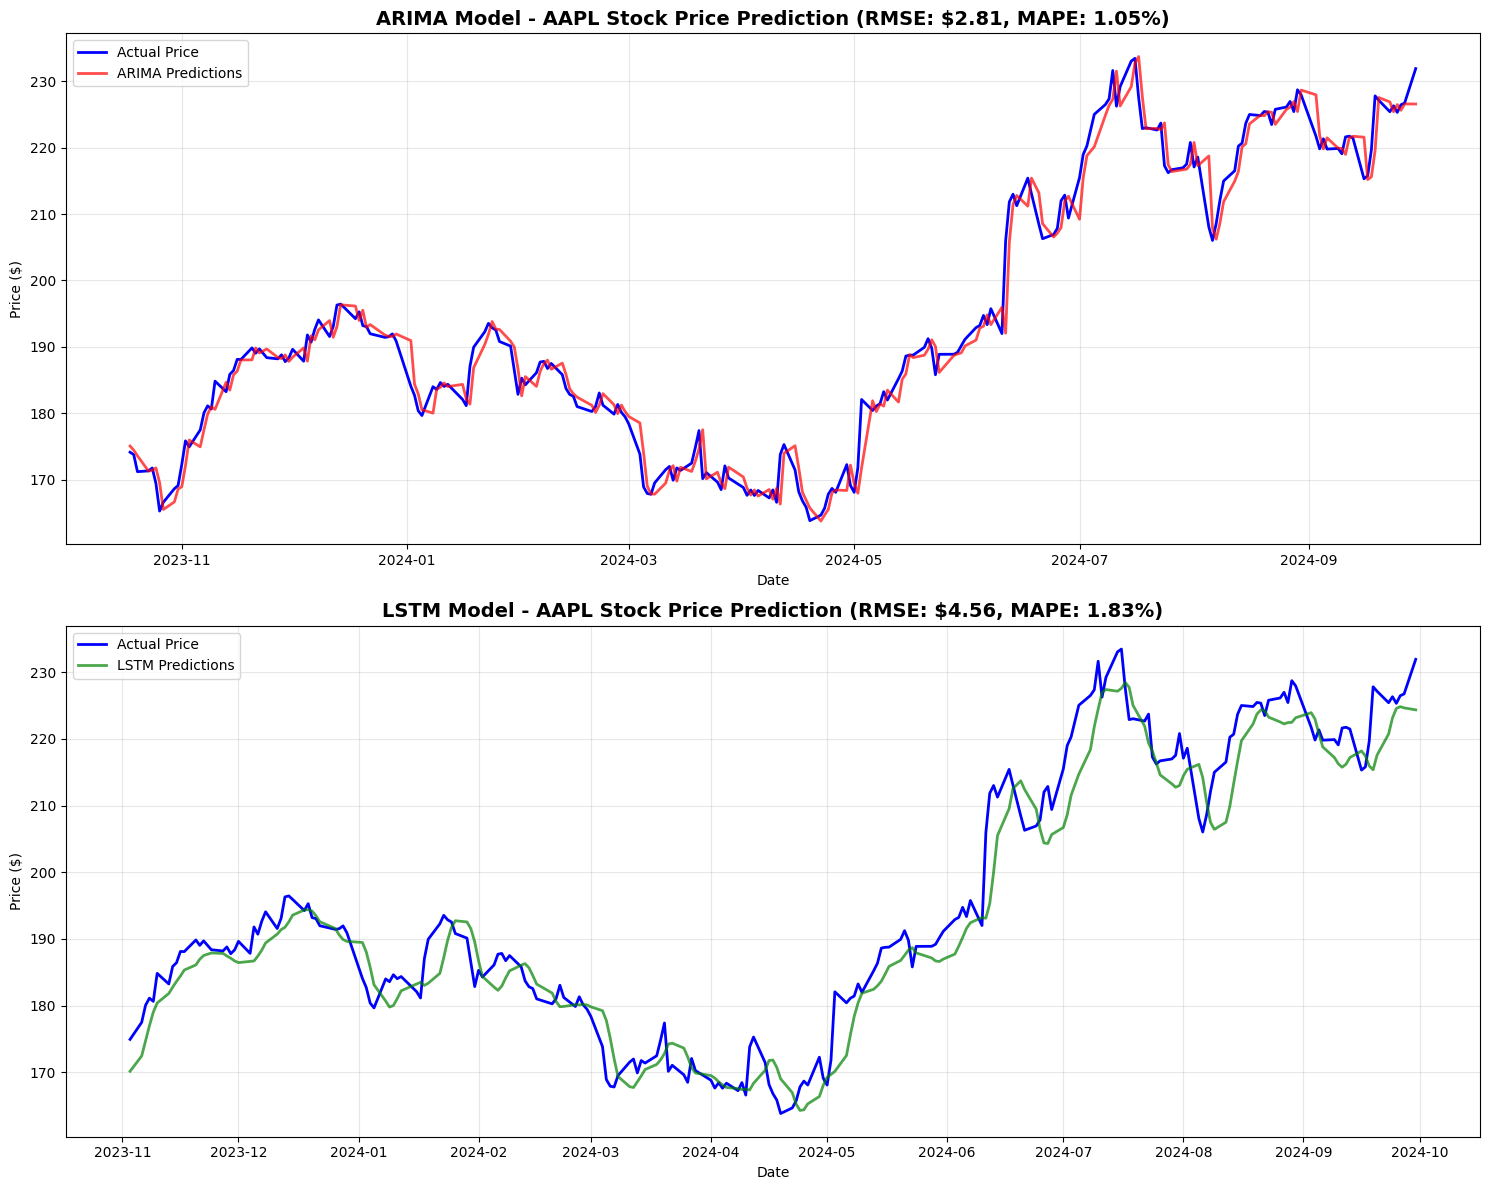

In [ ]:
print("\n[12] PERFORMANCE COMPARISON")
print("=" * 80)

results = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [arima_rmse, lstm_rmse],
    'MAPE': [arima_mape, lstm_mape]
})

print("\nPerformance Metrics:")
print(results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# ARIMA plot
axes[0].plot(test_data.index, actual_values, label='Actual Price', linewidth=2, color='blue')
axes[0].plot(test_data.index[:len(arima_predictions)], arima_predictions,
             label='ARIMA Predictions', linewidth=2, color='red', alpha=0.7)
axes[0].set_title(f'ARIMA Model - {ticker} Stock Price Prediction (RMSE: ${arima_rmse:.2f}, MAPE: {arima_mape:.2f}%)',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LSTM plot
axes[1].plot(df.index[train_size_lstm + seq_length:], y_test_actual,
             label='Actual Price', linewidth=2, color='blue')
axes[1].plot(lstm_pred_series.index, lstm_predictions,
             label='LSTM Predictions', linewidth=2, color='green', alpha=0.7)
axes[1].set_title(f'LSTM Model - {ticker} Stock Price Prediction (RMSE: ${lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}%)',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualization: model_comparison.png")


# **5. RECOMMENDATION AND DISCUSSION**

In [ ]:
print("\n[13] MODEL RECOMMENDATION")
print("=" * 80)

if arima_rmse < lstm_rmse:
    best_model_name = "ARIMA"
    print(f"✓ ARIMA performs better with {((lstm_rmse - arima_rmse) / lstm_rmse * 100):.2f}% lower RMSE")
else:
    best_model_name = "LSTM"
    print(f"✓ LSTM performs better with {((arima_rmse - lstm_rmse) / arima_rmse * 100):.2f}% lower RMSE")

print(f"\nRecommendation: Deploy {best_model_name} model")


[13] MODEL RECOMMENDATION
✓ ARIMA performs better with 38.33% lower RMSE

Recommendation: Deploy ARIMA model


# **6. MODEL DEPLOYMENT PREPARATION**

In [ ]:
print("\n[14] MODEL SAVING FOR DEPLOYMENT")
print("-" * 80)

if best_model_name == "LSTM":
    model.save('best_stock_model.h5')
    print("✓ LSTM model saved: best_stock_model.h5")

    # Save scaler
    import joblib
    joblib.dump(scaler, 'scaler.pkl')
    print("✓ Scaler saved: scaler.pkl")
else:
    best_model.save('best_arima_model.pkl')
    print("✓ ARIMA model saved: best_arima_model.pkl")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


[14] MODEL SAVING FOR DEPLOYMENT
--------------------------------------------------------------------------------
✓ ARIMA model saved: best_arima_model.pkl

ANALYSIS COMPLETE


# **Download Dataset and Model to computer**

In [15]:
# Save the dataset
data.to_csv('AAPL_Stock_Data.csv')



from google.colab import files
files.download('AAPL_Stock_Data.csv')

import pickle
#Save the ARIMA model
with open('best_arima_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

from google.colab import files
files.download('best_arima_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>